In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

path = "./data/all_data.csv"
df = pd.read_csv(path)

In [122]:
df.head()

,Unnamed: 0,Perimetre,Nature,Date,Heures,y,Thermique,Nucleaire,Eolien,Solaire,Hydraulique,Pompage,Bioenergies,Ech. physiques
0,0,Ile-de-France,Donn�es d�finitives,2016-01-01,00:00,8885.0,293.0,-,18.0,0.0,10.0,-,137.0,8428.0
1,1,Ile-de-France,Donn�es d�finitives,2016-01-01,00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Ile-de-France,Donn�es d�finitives,2016-01-01,00:30,8709.0,309.0,-,16.0,0.0,10.0,-,148.0,8226.0
3,3,Ile-de-France,Donn�es d�finitives,2016-01-01,00:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Ile-de-France,Donn�es d�finitives,2016-01-01,01:00,8343.0,309.0,-,13.0,0.0,10.0,-,149.0,7864.0


Train, validation, test split

In [123]:
df_cons = df[["y"]]
df_cons = df_cons.dropna()

# column_indices = {name: i for i, name in enumerate(df_cons.columns)}

n = len(df_cons)
train_df = df_cons[0:int(n*0.7)]
val_df = df_cons[int(n*0.7):int(n*0.9)]
test_df = df_cons[int(n*0.9):]

num_features = 1

Normalising the data

In [124]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [125]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [126]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [127]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [128]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [129]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['y'])
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [130]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [131]:
def plot(self, model=None, plot_col='y', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

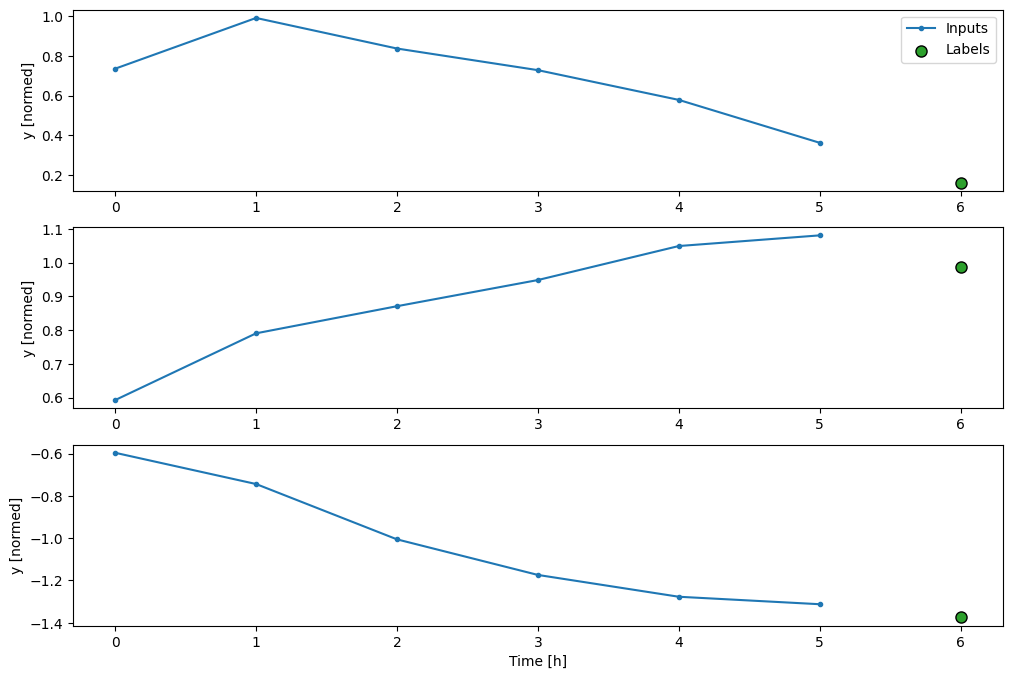

In [132]:
w2.plot()

Creating single step window for single step predictions

In [133]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['y'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['y']

In [134]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


Linear model (Basic mmodel)

In [135]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [136]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1919/1919 [==============================] - 4s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0906 - val_loss: 0.0112 - val_mean_absolute_error: 0.0819
Epoch 2/20
1919/1919 [==============================] - 3s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0901 - val_loss: 0.0112 - val_mean_absolute_error: 0.0819
Epoch 3/20
1919/1919 [==============================] - 3s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0901 - val_loss: 0.0112 - val_mean_absolute_error: 0.0819
Epoch 4/20
549/549 [==============================] - 1s 1ms/step - loss: 0.0112 - mean_absolute_error: 0.0819


In [137]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['y'])

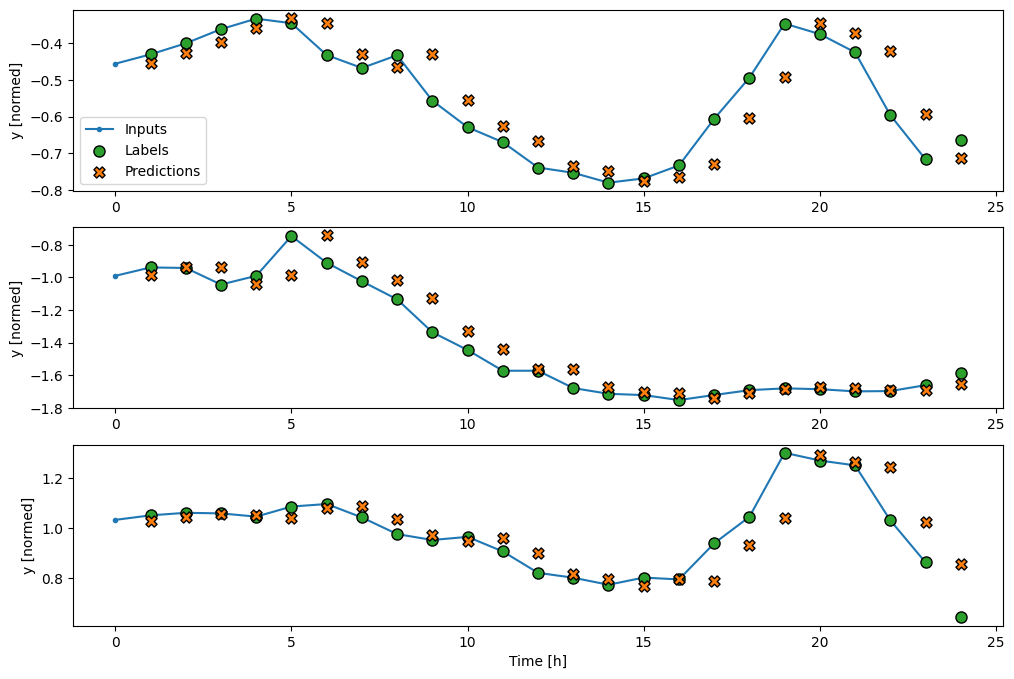

In [138]:
wide_window.plot(linear)